In [0]:
from nltk.corpus import sentiwordnet as swn

In [0]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import wordnet 
syns = wordnet.synsets("program") 


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [0]:
#These are kerras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [0]:
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [0]:
# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [0]:
print(syns[0].name())

plan.n.01


In [0]:
syns = wordnet.synsets("good") 
breakdown = swn.senti_synset(syns[0].name())
print(breakdown)

<good.n.01: PosScore=0.5 NegScore=0.0>


In [0]:

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

import pandas as pd


In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8


# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [0]:
dataset_path = "/content/drive/My Drive/training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/My Drive/training.1600000.processed.noemoticon.csv


In [0]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [0]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."



Map target label to String

    0 -> NEGATIVE
    2 -> NEUTRAL
    4 -> POSITIVE



In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]


In [0]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 460 ms, sys: 0 ns, total: 460 ms
Wall time: 462 ms


In [0]:
#This is the result after applying the labelling to target(sentiment) 
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Dataset labels distribuition')

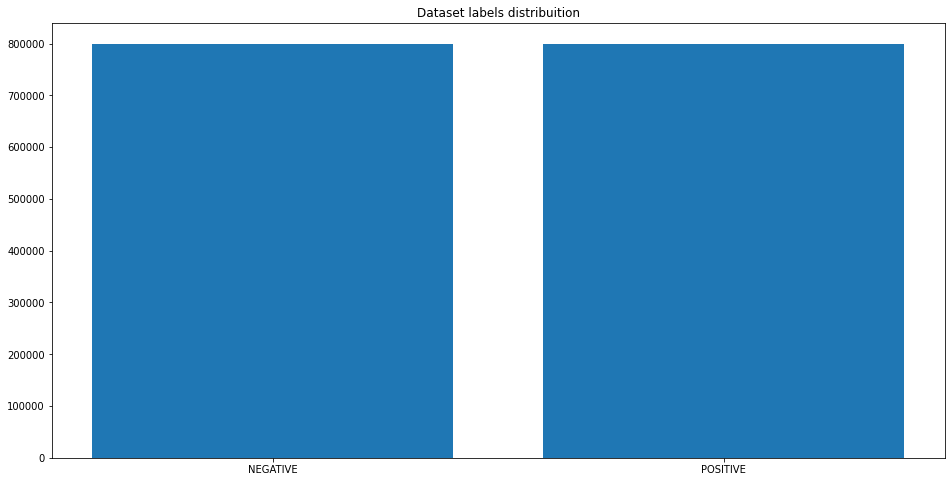

In [0]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [0]:
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()  
    ''''In re. sub() , specify a regular expression pattern in the first argument,
     a new string in the second argument, and a string to be processed in the third argument'''
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [0]:
#Here I am preprocessing the entire dataset
df.text = df.text.apply(lambda x: preprocess(x))

In [0]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


Below is the process done for word2vec

In [0]:
documents = [_text.split() for _text in df_train.text] 

In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

In [0]:
#This will train the model
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 19min 10s, sys: 3.31 s, total: 19min 13s
Wall time: 9min 48s


(263125644, 295270528)

In [0]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5530692934989929),
 ('loves', 0.5498942136764526),
 ('loved', 0.5399725437164307),
 ('adore', 0.5030851364135742),
 ('amazing', 0.49841439723968506),
 ('looove', 0.4885849952697754),
 ('awesome', 0.45904719829559326),
 ('lovee', 0.43481284379959106),
 ('miss', 0.43404024839401245),
 ('loveee', 0.4333076477050781)]

In [0]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 16.4 s, sys: 153 ms, total: 16.6 s
Wall time: 16.5 s


In [0]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 24.5 s, sys: 450 ms, total: 24.9 s
Wall time: 24.9 s


In [0]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [0]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)



y_train (1280000, 1)
y_test (320000, 1)


In [0]:


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)



x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [0]:
#Embedding Layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [0]:
#Here I am building model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [0]:
#Here I am compiling the model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
#This is for callbacks


callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]



In [0]:
#Here I am training the model
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 583s 506us/step - loss: 0.9657 - accuracy: 0.6081 - val_loss: 0.6366 - val_accuracy: 0.6545
Epoch 2/8


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 582s 505us/step - loss: 0.6153 - accuracy: 0.6782 - val_loss: 0.5793 - val_accuracy: 0.6988
Epoch 3/8
1152000/1152000 [==============================] - 586s 509us/step - loss: 0.5996 - accuracy: 0.6907 - val_loss: 0.5407 - val_accuracy: 0.7401
Epoch 4/8
1152000/1152000 [==============================] - 581s 504us/step - loss: 0.5587 - accuracy: 0.7214 - val_loss: 0.5177 - val_accuracy: 0.7530
Epoch 5/8
1152000/1152000 [==============================] - 580s 503us/step - loss: 0.5342 - accuracy: 0.7364 - val_loss: 0.5014 - val_accuracy: 0.7629
Epoch 6/8
1152000/1152000 [==============================] - 580s 503us/step - loss: 0.5233 - accuracy: 0.7422 - val_loss: 0.4918 - val_accuracy: 0.7624
Epoch 7/8
1152000/1152000 [==============================] - 580s 504us/step - loss: 0.5146 - accuracy: 0.7473 - val_loss: 0.4826 - val_accuracy: 0.7684
Epoch 8/8
1152000/1152000 [==============================] - 580s 503us/step - loss: 0.5151 

In [0]:


%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])



320000/320000 [==============================] - 36s 114us/step

ACCURACY: 0.7691875100135803
LOSS: 0.48308800258636475
CPU times: user 23.5 s, sys: 8.44 s, total: 31.9 s
Wall time: 36.4 s


In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


In [0]:
predict("I love the music")

{'elapsed_time': 0.045774221420288086,
 'label': 'POSITIVE',
 'score': 0.9804787039756775}

In [0]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=4000)

320000/320000 [==============================] - 36s 113us/step


In [0]:
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [0]:
#This will give the classification report
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.72      0.76    159494
    POSITIVE       0.75      0.82      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

